# Análisis 2018

In [14]:
import pandas as pd
import numpy as np
import os

# --- CONFIGURACIÓN DE RUTAS PARA 2018 ---
# Asegúrate de que los nombres de archivo coincidan con los que descargaste.
ruta_base = '../data/enigh_2018/'

# Nombres de archivo
archivo_hogares = 'hogares.csv'
archivo_pobreza = 'pobreza18.csv' 
archivo_gastos = 'gastoshogar.csv'

# Rutas completas
path_hogares_18 = f'{ruta_base}{archivo_hogares}'
path_pobreza_18 = f'{ruta_base}{archivo_pobreza}'
path_gastos_18 = f'{ruta_base}{archivo_gastos}'

print("Rutas definidas para el análisis de 2018.")

Rutas definidas para el análisis de 2018.


In [19]:
# --- CARGA Y PREPARACIÓN DE DATOS ---

# 1. Cargar los archivos CSV
print("Cargando archivos...")
df_hogares_18 = pd.read_csv(path_hogares_18, low_memory=False)
df_pobreza_18 = pd.read_csv(path_pobreza_18, low_memory=False)
df_gastos_18 = pd.read_csv(path_gastos_18, low_memory=False)
print("Archivos cargados.")

# 2. Preparar Base de Pobreza e Ingresos (a nivel hogar)
print("Procesando datos de pobreza e ingreso...")
columnas_pobreza = ['folioviv', 'pobreza', 'pobreza_e', 'ict',"rurubr"]
df_pobreza_18_hogar = df_pobreza_18[columnas_pobreza].drop_duplicates(subset='folioviv').copy()

# 3. Preparar Base de Gastos (a nivel hogar y mensual)
print("Procesando datos de gasto...")
# Filtrar por clave de gasto y tipo de gasto monetario
df_gastos_18['clave'] = df_gastos_18['clave'].astype(str)
gastos_celular_18 = df_gastos_18[
    (df_gastos_18['clave'] == 'F003') & 
    (df_gastos_18['tipo_gasto'] == 'G1')
].copy()

# Convertir gasto a numérico (a prueba de errores)
gastos_celular_18['gasto_tri'] = pd.to_numeric(gastos_celular_18['gasto_tri'], errors='coerce')

# Agrupar, sumar gasto trimestral y convertir a mensual
df_gasto_agregado_18 = gastos_celular_18.groupby('folioviv')['gasto_tri'].sum().reset_index()
df_gasto_agregado_18['gasto_celular'] = df_gasto_agregado_18['gasto_tri'] / 3
df_gasto_cel_18 = df_gasto_agregado_18[['folioviv', 'gasto_celular']]

print("Preparación de datos completada.")

Cargando archivos...
Archivos cargados.
Procesando datos de pobreza e ingreso...
Procesando datos de gasto...
Preparación de datos completada.


In [20]:
# --- UNIÓN DE BASES DE DATOS ---

print("Uniendo las bases de datos...")
# 1. Unir hogares con pobreza e ingreso
df_merged_18 = pd.merge(df_hogares_18, df_pobreza_18_hogar, on='folioviv', how='left')

# 2. Unir con el gasto mensual en celular
df_final_18 = pd.merge(df_merged_18, df_gasto_cel_18, on='folioviv', how='left')

# 3. Limpieza post-unión (llenar gastos no existentes con 0)
df_final_18['gasto_celular'].fillna(0, inplace=True)

print("Unión de datos finalizada. DataFrame 'df_final_18' creado.")
print(f"El DataFrame final tiene {df_final_18.shape[0]} filas.")

Uniendo las bases de datos...
Unión de datos finalizada. DataFrame 'df_final_18' creado.
El DataFrame final tiene 74647 filas.


In [21]:
# --- CREACIÓN DE VARIABLES DE ANÁLISIS ---

# 1. Crear 'pct_gasto_celular' usando 'ict'
df_final_18['pct_gasto_celular'] = np.where(
    (df_final_18['ict'] > 0) & (df_final_18['ict'].notna()),
    (df_final_18['gasto_celular'] / df_final_18['ict']) * 100,
    0
)

# 2. Crear 'categoria_conexion'
df_final_18['celular'] = pd.to_numeric(df_final_18['celular'], errors='coerce')
df_final_18['conex_inte'] = pd.to_numeric(df_final_18['conex_inte'], errors='coerce')

conditions = [
    df_final_18['celular'] == 2,
    (df_final_18['celular'] == 1) & (df_final_18['conex_inte'] != 1),
    (df_final_18['celular'] == 1) & (df_final_18['conex_inte'] == 1)
]
choices = ['1. Sin Celular', '2. Con Celular, Sin Internet', '3. Con Celular y Con Internet']
df_final_18['categoria_conexion'] = np.select(conditions, choices, default='Dato Faltante')

print("Variables finales 'pct_gasto_celular' y 'categoria_conexion' creadas.")

Variables finales 'pct_gasto_celular' y 'categoria_conexion' creadas.


In [27]:
# --- MÉTRICA 1: ACCESO A CELULAR POR CATEGORÍAS (PONDERADO) ---

# Requisitos: Columnas 'tiene_celular' y 'numerador_pond' de la celda 4.
# DataFrames df_pobreza y df_pobreza_ext de esta misma celda.

# Definir grupos si no se ha hecho
df_pobreza = df_final_18[df_final_18['pobreza'] == 1].copy()
df_pobreza_ext = df_final_18[df_final_18['pobreza_e'] == 1].copy()

# 1. Cálculos para HOGARES TOTALES
total_hogares_nac = df_final_18['factor'].sum()
hogares_con_cel_nac = df_final_18['numerador_pond'].sum()
pct_total = (hogares_con_cel_nac / total_hogares_nac) * 100

# 2. Cálculos para HOGARES EN POBREZA
total_hogares_pob = df_pobreza['factor'].sum()
hogares_con_cel_pob = df_pobreza['numerador_pond'].sum()
pct_pobreza = (hogares_con_cel_pob / total_hogares_pob) * 100

# 3. Cálculos para HOGARES EN POBREZA EXTREMA
total_hogares_pob_ext = df_pobreza_ext['factor'].sum()
hogares_con_cel_pob_ext = df_pobreza_ext['numerador_pond'].sum()
pct_pobreza_ext = (hogares_con_cel_pob_ext / total_hogares_pob_ext) * 100

# 4. Consolidar los resultados en una tabla
resultados_acceso = {
    'Grupo': ['Hogares Totales', 'Hogares en Pobreza', 'Hogares en Pobreza Extrema'],
    'Porcentaje_Acceso': [pct_total, pct_pobreza, pct_pobreza_ext],
    'Hogares_Con_Celular': [hogares_con_cel_nac, hogares_con_cel_pob, hogares_con_cel_pob_ext],
    'Total_Hogares': [total_hogares_nac, total_hogares_pob, total_hogares_pob_ext]
}
df_resumen_acceso = pd.DataFrame(resultados_acceso)

# Formatear para mejor visualización
df_resumen_acceso['Porcentaje_Acceso'] = df_resumen_acceso['Porcentaje_Acceso'].map('{:.2f}%'.format)
df_resumen_acceso['Hogares_Con_Celular'] = df_resumen_acceso['Hogares_Con_Celular'].map('{:,.0f}'.format)
df_resumen_acceso['Total_Hogares'] = df_resumen_acceso['Total_Hogares'].map('{:,.0f}'.format)

print("\n--- MÉTRICA 1: Porcentaje y Nro. de Hogares con Celular por Categoría (2018) ---")
print(df_resumen_acceso)


--- MÉTRICA 1: Porcentaje y Nro. de Hogares con Celular por Categoría (2018) ---
                        Grupo Porcentaje_Acceso Hogares_Con_Celular  \
0             Hogares Totales            86.11%          29,621,977   
1          Hogares en Pobreza            77.29%           9,721,540   
2  Hogares en Pobreza Extrema            59.70%           1,301,343   

  Total_Hogares  
0    34,400,515  
1    12,577,228  
2     2,179,641  


In [28]:
# --- MÉTRICA 2: CALIDAD DE CONEXIÓN POR CATEGORÍAS (PONDERADO) ---

# Función auxiliar para calcular los números absolutos ponderados
def calcular_absolutos(df, columna_categoria):
    return df.groupby(columna_categoria)['factor'].sum()

# 1. Calcular números absolutos para cada grupo
abs_total = calcular_absolutos(df_final_18, 'categoria_conexion')
abs_pobreza = calcular_absolutos(df_pobreza, 'categoria_conexion')
abs_pobreza_ext = calcular_absolutos(df_pobreza_ext, 'categoria_conexion')

# 2. Consolidar absolutos en una tabla y formatear
df_resumen_conexion_abs = pd.DataFrame({
    'Hogares Totales': abs_total,
    'Hogares en Pobreza': abs_pobreza,
    'Hogares en Pobreza Extrema': abs_pobreza_ext
}).transpose().fillna(0)

# 3. Calcular porcentajes (como antes)
df_resumen_conexion_pct = df_resumen_conexion_abs.div(df_resumen_conexion_abs.sum(axis=1), axis=0) * 100

print("\n--- MÉTRICA 2: NÚMERO de Hogares por Calidad de Conexión (2018) ---")
print(df_resumen_conexion_abs.applymap('{:,.0f}'.format))

print("\n--- MÉTRICA 2: PORCENTAJE de Hogares por Calidad de Conexión (2018) ---")
print(df_resumen_conexion_pct.round(2))


--- MÉTRICA 2: NÚMERO de Hogares por Calidad de Conexión (2018) ---
categoria_conexion         1. Sin Celular 2. Con Celular, Sin Internet  \
Hogares Totales                 4,778,538                   16,321,333   
Hogares en Pobreza              2,855,688                    7,571,691   
Hogares en Pobreza Extrema        878,298                    1,230,659   

categoria_conexion         3. Con Celular y Con Internet  
Hogares Totales                               13,300,644  
Hogares en Pobreza                             2,149,849  
Hogares en Pobreza Extrema                        70,684  

--- MÉTRICA 2: PORCENTAJE de Hogares por Calidad de Conexión (2018) ---
categoria_conexion          1. Sin Celular  2. Con Celular, Sin Internet  \
Hogares Totales                      13.89                         47.45   
Hogares en Pobreza                   22.71                         60.20   
Hogares en Pobreza Extrema           40.30                         56.46   

categoria_conexion  

In [26]:
# --- MÉTRICA 3: GASTO PROMEDIO EN CELULAR POR CATEGORÍAS (PONDERADO) ---

def calcular_promedio_ponderado(df, col_valor):
    return (df[col_valor] * df['factor']).sum() / df['factor'].sum()

resultados_gasto = pd.DataFrame({
    'Grupo': ['Hogares Totales', 'Hogares en Pobreza', 'Hogares en Pobreza Extrema'],
    'Gasto_Promedio_Mensual_MXN': [
        calcular_promedio_ponderado(df_final_18, 'gasto_celular'),
        calcular_promedio_ponderado(df_pobreza, 'gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_ext, 'gasto_celular')
    ],
    'Porcentaje_Promedio_del_Ingreso': [
        calcular_promedio_ponderado(df_final_18, 'pct_gasto_celular'),
        calcular_promedio_ponderado(df_pobreza, 'pct_gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_ext, 'pct_gasto_celular')
    ]
})

print("\n--- MÉTRICA 3: Gasto Promedio en Celular (2018) ---")
print(resultados_gasto.round(2))


--- MÉTRICA 3: Gasto Promedio en Celular (2018) ---
                        Grupo  Gasto_Promedio_Mensual_MXN  \
0             Hogares Totales                      152.35   
1          Hogares en Pobreza                      111.14   
2  Hogares en Pobreza Extrema                       57.75   

   Porcentaje_Promedio_del_Ingreso  
0                             1.45  
1                             1.89  
2                             2.02  


# Análisis 2020

In [35]:
# ===================================================================
# ANÁLISIS DE ACCESO A CELULAR Y GASTO EN HOGARES - ENIGH 2020 (CORREGIDO)
# ===================================================================

import pandas as pd
import numpy as np
import os

# --- Celda 1: Configuración Inicial - Librerías y Rutas ---
print("--- INICIANDO ANÁLISIS 2020 ---")
ruta_base_20 = '../data/enigh_2020/'

# Nombres de archivo (verifica que coincidan con tus archivos de 2020)
archivo_hogares_20 = 'hogares.csv'
archivo_pobreza_20 = 'pobreza20.csv' 
archivo_gastos_20 = 'gastoshogar.csv'

# Rutas completas
path_hogares_20 = f'{ruta_base_20}{archivo_hogares_20}'
path_pobreza_20 = f'{ruta_base_20}{archivo_pobreza_20}'
path_gastos_20 = f'{ruta_base_20}{archivo_gastos_20}'

print("Rutas definidas para 2020.")



--- INICIANDO ANÁLISIS 2020 ---
Rutas definidas para 2020.


In [36]:
# --- Celda 2: Carga y Preparación de Datos Fuente ---
print("\nCargando y preparando datos de 2020...")
# 1. Cargar archivos
df_hogares_20 = pd.read_csv(path_hogares_20, low_memory=False)
df_pobreza_20 = pd.read_csv(path_pobreza_20, low_memory=False)
df_gastos_20 = pd.read_csv(path_gastos_20, low_memory=False)

# 2. Preparar Pobreza e Ingreso (a nivel hogar)
columnas_pobreza = ['folioviv', 'pobreza', 'pobreza_e', 'ict', "factor"]
df_pobreza_20_hogar = df_pobreza_20[columnas_pobreza].drop_duplicates(subset='folioviv').copy()

# 3. Preparar Gastos (a nivel hogar y mensual)
df_gastos_20['clave'] = df_gastos_20['clave'].astype(str)
gastos_celular_20 = df_gastos_20[
    (df_gastos_20['clave'] == 'F003') & 
    (df_gastos_20['tipo_gasto'] == 'G1')
].copy()
gastos_celular_20['gasto_tri'] = pd.to_numeric(gastos_celular_20['gasto_tri'], errors='coerce')
df_gasto_agregado_20 = gastos_celular_20.groupby('folioviv')['gasto_tri'].sum().reset_index()
df_gasto_agregado_20['gasto_celular'] = df_gasto_agregado_20['gasto_tri'] / 3
df_gasto_cel_20 = df_gasto_agregado_20[['folioviv', 'gasto_celular']]
print("Datos fuente procesados.")




Cargando y preparando datos de 2020...
Datos fuente procesados.


In [37]:
# --- Celda 3: Unión de las Bases de Datos ---
print("\nUniendo bases de datos...")
df_merged_20 = pd.merge(df_hogares_20, df_pobreza_20_hogar, on='folioviv', how='left')
df_final_20 = pd.merge(df_merged_20, df_gasto_cel_20, on='folioviv', how='left')
df_final_20['gasto_celular'].fillna(0, inplace=True)
print("DataFrame 'df_final_20' creado.")




Uniendo bases de datos...
DataFrame 'df_final_20' creado.


In [38]:
# --- Celda 4: Creación de Variables Finales de Análisis ---
print("\nCreando variables de análisis...")
df_final_20['pct_gasto_celular'] = np.where(
    (df_final_20['ict'] > 0) & (df_final_20['ict'].notna()),
    (df_final_20['gasto_celular'] / df_final_20['ict']) * 100,
    0
)
df_final_20['celular'] = pd.to_numeric(df_final_20['celular'], errors='coerce')
df_final_20['conex_inte'] = pd.to_numeric(df_final_20['conex_inte'], errors='coerce')
conditions = [
    df_final_20['celular'] == 2,
    (df_final_20['celular'] == 1) & (df_final_20['conex_inte'] != 1),
    (df_final_20['celular'] == 1) & (df_final_20['conex_inte'] == 1)
]
choices = ['1. Sin Celular', '2. Con Celular, Sin Internet', '3. Con Celular y Con Internet']
df_final_20['categoria_conexion'] = np.select(conditions, choices, default='Dato Faltante')
print("Variables finales creadas.")




Creando variables de análisis...
Variables finales creadas.


In [39]:
# --- Celda 5: Análisis - Métricas (ORDEN CORREGIDO) ---
print("\n--- GENERANDO RESULTADOS PARA 2020 ---")

# --- MÉTRICA 1: ACCESO ---
# 1. PRIMERO, creamos las columnas auxiliares en el DataFrame principal
df_final_20['tiene_celular'] = np.where(df_final_20['celular'] == 1, 1, 0)
df_final_20['numerador_pond'] = df_final_20['tiene_celular'] * df_final_20['factor']

# 2. AHORA, creamos los DataFrames filtrados (que ya incluirán las nuevas columnas)
df_pobreza_20_filt = df_final_20[df_final_20['pobreza'] == 1].copy()
df_pobreza_ext_20_filt = df_final_20[df_final_20['pobreza_e'] == 1].copy()

# 3. El resto de los cálculos ahora funcionarán correctamente
# Cálculos
total_hogares_nac = df_final_20['factor'].sum()
hogares_con_cel_nac = df_final_20['numerador_pond'].sum()
pct_total = (hogares_con_cel_nac / total_hogares_nac) * 100

total_hogares_pob = df_pobreza_20_filt['factor'].sum()
hogares_con_cel_pob = df_pobreza_20_filt['numerador_pond'].sum()
pct_pobreza = (hogares_con_cel_pob / total_hogares_pob) * 100

total_hogares_pob_ext = df_pobreza_ext_20_filt['factor'].sum()
hogares_con_cel_pob_ext = df_pobreza_ext_20_filt['numerador_pond'].sum()
pct_pobreza_ext = (hogares_con_cel_pob_ext / total_hogares_pob_ext) * 100

# Consolidar
resultados_acceso_20 = pd.DataFrame({
    'Grupo': ['Hogares Totales', 'Hogares en Pobreza', 'Hogares en Pobreza Extrema'],
    'Porcentaje_Acceso': [pct_total, pct_pobreza, pct_pobreza_ext],
    'Hogares_Con_Celular': [hogares_con_cel_nac, hogares_con_cel_pob, hogares_con_cel_pob_ext],
    'Total_Hogares': [total_hogares_nac, total_hogares_pob, total_hogares_pob_ext]
})
resultados_acceso_20['Porcentaje_Acceso'] = resultados_acceso_20['Porcentaje_Acceso'].map('{:.2f}%'.format)
resultados_acceso_20['Hogares_Con_Celular'] = resultados_acceso_20['Hogares_Con_Celular'].map('{:,.0f}'.format)
resultados_acceso_20['Total_Hogares'] = resultados_acceso_20['Total_Hogares'].map('{:,.0f}'.format)

print("\n--- MÉTRICA 1: Porcentaje y Nro. de Hogares con Celular por Categoría (2020) ---")
print(resultados_acceso_20)


# --- MÉTRICA 2: CALIDAD DE CONEXIÓN ---
def calcular_absolutos(df, columna_categoria):
    return df.groupby(columna_categoria)['factor'].sum()
abs_total = calcular_absolutos(df_final_20, 'categoria_conexion')
abs_pobreza = calcular_absolutos(df_pobreza_20_filt, 'categoria_conexion')
abs_pobreza_ext = calcular_absolutos(df_pobreza_ext_20_filt, 'categoria_conexion')
df_resumen_conexion_abs_20 = pd.DataFrame({
    'Hogares Totales': abs_total, 'Hogares en Pobreza': abs_pobreza, 'Hogares en Pobreza Extrema': abs_pobreza_ext
}).transpose().fillna(0)
df_resumen_conexion_pct_20 = df_resumen_conexion_abs_20.div(df_resumen_conexion_abs_20.sum(axis=1), axis=0) * 100

print("\n--- MÉTRICA 2: NÚMERO de Hogares por Calidad de Conexión (2020) ---")
print(df_resumen_conexion_abs_20.applymap('{:,.0f}'.format))
print("\n--- MÉTRICA 2: PORCENTAJE de Hogares por Calidad de Conexión (2020) ---")
print(df_resumen_conexion_pct_20.round(2))


# --- MÉTRICA 3: GASTO PROMEDIO ---
def calcular_promedio_ponderado(df, col_valor):
    df_no_na = df[[col_valor, 'factor']].dropna()
    return (df_no_na[col_valor] * df_no_na['factor']).sum() / df_no_na['factor'].sum()
resultados_gasto_20 = pd.DataFrame({
    'Grupo': ['Hogares Totales', 'Hogares en Pobreza', 'Hogares en Pobreza Extrema'],
    'Gasto_Promedio_Mensual_MXN': [
        calcular_promedio_ponderado(df_final_20, 'gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_20_filt, 'gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_ext_20_filt, 'gasto_celular')
    ],
    'Porcentaje_Promedio_del_Ingreso': [
        calcular_promedio_ponderado(df_final_20, 'pct_gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_20_filt, 'pct_gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_ext_20_filt, 'pct_gasto_celular')
    ]
})

print("\n--- MÉTRICA 3: Gasto Promedio en Celular (2020) ---")
print(resultados_gasto_20.round(2))

# --- Celda 6: Guardado del Resultado Final ---
ruta_guardado = '../data/procesados/'
if not os.path.exists(ruta_guardado):
    os.makedirs(ruta_guardado)
archivo_parquet_20 = f'{ruta_guardado}enigh_2020_final.parquet'
df_final_20.to_parquet(archivo_parquet_20)
print(f"\n¡Trabajo de 2020 completado y guardado en: {archivo_parquet_20}!")


--- GENERANDO RESULTADOS PARA 2020 ---

--- MÉTRICA 1: Porcentaje y Nro. de Hogares con Celular por Categoría (2020) ---
                        Grupo Porcentaje_Acceso Hogares_Con_Celular  \
0             Hogares Totales            90.12%          32,217,670   
1          Hogares en Pobreza            85.61%          11,591,414   
2  Hogares en Pobreza Extrema            75.97%           1,975,640   

  Total_Hogares  
0    35,749,659  
1    13,539,629  
2     2,600,480  

--- MÉTRICA 2: NÚMERO de Hogares por Calidad de Conexión (2020) ---
categoria_conexion         1. Sin Celular 2. Con Celular, Sin Internet  \
Hogares Totales                 3,531,989                   13,716,387   
Hogares en Pobreza              1,948,215                    7,153,643   
Hogares en Pobreza Extrema        624,840                    1,576,368   

categoria_conexion         3. Con Celular y Con Internet  
Hogares Totales                               18,501,283  
Hogares en Pobreza                   

# Análisis 2022

In [12]:
# ===================================================================
# ANÁLISIS DE ACCESO A CELULAR Y GASTO EN HOGARES - ENIGH 2022
# ===================================================================

import pandas as pd
import numpy as np
import os

# --- Celda 1: Configuración Inicial - Librerías y Rutas ---
print("--- INICIANDO ANÁLISIS 2022 ---")
# Apuntamos a la carpeta de datos de 2022
ruta_base_22 = '../data/enigh_2022/'

# Nombres de archivo (verifica que coincidan con tus archivos de 2022)
archivo_hogares_22 = 'hogares.csv'
archivo_pobreza_22 = 'pobreza22.csv' 
archivo_gastos_22 = 'gastoshogar.csv'

# Rutas completas
path_hogares_22 = f'{ruta_base_22}{archivo_hogares_22}'
path_pobreza_22 = f'{ruta_base_22}{archivo_pobreza_22}'
path_gastos_22 = f'{ruta_base_22}{archivo_gastos_22}'

print("Rutas definidas para 2022.")


--- INICIANDO ANÁLISIS 2022 ---
Rutas definidas para 2022.


In [17]:
# --- Celda 2: Carga y Preparación de Datos Fuente ---
print("\nCargando y preparando datos de 2022...")
# 1. Cargar archivos
df_hogares_22 = pd.read_csv(path_hogares_22, low_memory=False)
df_pobreza_22 = pd.read_csv(path_pobreza_22, low_memory=False)
df_gastos_22 = pd.read_csv(path_gastos_22, low_memory=False)

# 2. Preparar Pobreza e Ingreso (a nivel hogar)
columnas_pobreza = ['folioviv', 'pobreza', 'pobreza_e','ict']
df_pobreza_22_hogar = df_pobreza_22[columnas_pobreza].drop_duplicates(subset='folioviv').copy()

# 3. Preparar Gastos (a nivel hogar y mensual)
df_gastos_22['clave'] = df_gastos_22['clave'].astype(str)
gastos_celular_22 = df_gastos_22[
    (df_gastos_22['clave'] == 'F003') & 
    (df_gastos_22['tipo_gasto'] == 'G1')
].copy()
gastos_celular_22['gasto_tri'] = pd.to_numeric(gastos_celular_22['gasto_tri'], errors='coerce')
df_gasto_agregado_22 = gastos_celular_22.groupby('folioviv')['gasto_tri'].sum().reset_index()
df_gasto_agregado_22['gasto_celular'] = df_gasto_agregado_22['gasto_tri'] / 3
df_gasto_cel_22 = df_gasto_agregado_22[['folioviv', 'gasto_celular']]
print("Datos fuente procesados.")


Cargando y preparando datos de 2022...
Datos fuente procesados.


In [18]:
# --- Celda 3: Unión de las Bases de Datos ---
print("\nUniendo bases de datos...")
df_merged_22 = pd.merge(df_hogares_22, df_pobreza_22_hogar, on='folioviv', how='left')
df_final_22 = pd.merge(df_merged_22, df_gasto_cel_22, on='folioviv', how='left')
df_final_22['gasto_celular'].fillna(0, inplace=True)
print("DataFrame 'df_final_22' creado.")


Uniendo bases de datos...
DataFrame 'df_final_22' creado.


In [19]:
# --- Celda 4: Creación de Variables Finales de Análisis ---
print("\nCreando variables de análisis...")
df_final_22['pct_gasto_celular'] = np.where(
    (df_final_22['ict'] > 0) & (df_final_22['ict'].notna()),
    (df_final_22['gasto_celular'] / df_final_22['ict']) * 100,
    0
)
df_final_22['celular'] = pd.to_numeric(df_final_22['celular'], errors='coerce')
df_final_22['conex_inte'] = pd.to_numeric(df_final_22['conex_inte'], errors='coerce')
conditions = [
    df_final_22['celular'] == 2,
    (df_final_22['celular'] == 1) & (df_final_22['conex_inte'] != 1),
    (df_final_22['celular'] == 1) & (df_final_22['conex_inte'] == 1)
]
choices = ['1. Sin Celular', '2. Con Celular, Sin Internet', '3. Con Celular y Con Internet']
df_final_22['categoria_conexion'] = np.select(conditions, choices, default='Dato Faltante')
print("Variables finales creadas.")


Creando variables de análisis...
Variables finales creadas.


In [20]:
# --- Celda 5: Análisis - Métricas ---
print("\n--- GENERANDO RESULTADOS PARA 2022 ---")
# 1. Crear columnas auxiliares en el DataFrame principal
df_final_22['tiene_celular'] = np.where(df_final_22['celular'] == 1, 1, 0)
df_final_22['numerador_pond'] = df_final_22['tiene_celular'] * df_final_22['factor']

# 2. Crear los DataFrames filtrados
df_pobreza_22_filt = df_final_22[df_final_22['pobreza'] == 1].copy()
df_pobreza_ext_22_filt = df_final_22[df_final_22['pobreza_e'] == 1].copy()


--- GENERANDO RESULTADOS PARA 2022 ---


In [21]:
# --- MÉTRICA 1: ACCESO ---
total_hogares_nac = df_final_22['factor'].sum()
hogares_con_cel_nac = df_final_22['numerador_pond'].sum()
pct_total = (hogares_con_cel_nac / total_hogares_nac) * 100
total_hogares_pob = df_pobreza_22_filt['factor'].sum()
hogares_con_cel_pob = df_pobreza_22_filt['numerador_pond'].sum()
pct_pobreza = (hogares_con_cel_pob / total_hogares_pob) * 100
total_hogares_pob_ext = df_pobreza_ext_22_filt['factor'].sum()
hogares_con_cel_pob_ext = df_pobreza_ext_22_filt['numerador_pond'].sum()
pct_pobreza_ext = (hogares_con_cel_pob_ext / total_hogares_pob_ext) * 100
# Consolidar
resultados_acceso_22 = pd.DataFrame({
    'Grupo': ['Hogares Totales', 'Hogares en Pobreza', 'Hogares en Pobreza Extrema'],
    'Porcentaje_Acceso': [pct_total, pct_pobreza, pct_pobreza_ext],
    'Hogares_Con_Celular': [hogares_con_cel_nac, hogares_con_cel_pob, hogares_con_cel_pob_ext],
    'Total_Hogares': [total_hogares_nac, total_hogares_pob, total_hogares_pob_ext]
})
resultados_acceso_22['Porcentaje_Acceso'] = resultados_acceso_22['Porcentaje_Acceso'].map('{:.2f}%'.format)
resultados_acceso_22['Hogares_Con_Celular'] = resultados_acceso_22['Hogares_Con_Celular'].map('{:,.0f}'.format)
resultados_acceso_22['Total_Hogares'] = resultados_acceso_22['Total_Hogares'].map('{:,.0f}'.format)

print("\n--- MÉTRICA 1: Porcentaje y Nro. de Hogares con Celular por Categoría (2022) ---")
print(resultados_acceso_22)



--- MÉTRICA 1: Porcentaje y Nro. de Hogares con Celular por Categoría (2022) ---
                        Grupo Porcentaje_Acceso Hogares_Con_Celular  \
0             Hogares Totales            92.31%          34,672,740   
1          Hogares en Pobreza            87.81%          10,020,745   
2  Hogares en Pobreza Extrema            79.91%           1,717,882   

  Total_Hogares  
0    37,560,123  
1    11,411,279  
2     2,149,770  


In [22]:
# --- MÉTRICA 2: CALIDAD DE CONEXIÓN ---
def calcular_absolutos(df, columna_categoria):
    return df.groupby(columna_categoria)['factor'].sum()
abs_total = calcular_absolutos(df_final_22, 'categoria_conexion')
abs_pobreza = calcular_absolutos(df_pobreza_22_filt, 'categoria_conexion')
abs_pobreza_ext = calcular_absolutos(df_pobreza_ext_22_filt, 'categoria_conexion')
df_resumen_conexion_abs_22 = pd.DataFrame({
    'Hogares Totales': abs_total, 'Hogares en Pobreza': abs_pobreza, 'Hogares en Pobreza Extrema': abs_pobreza_ext
}).transpose().fillna(0)
df_resumen_conexion_pct_22 = df_resumen_conexion_abs_22.div(df_resumen_conexion_abs_22.sum(axis=1), axis=0) * 100

print("\n--- MÉTRICA 2: NÚMERO de Hogares por Calidad de Conexión (2022) ---")
print(df_resumen_conexion_abs_22.applymap('{:,.0f}'.format))
print("\n--- MÉTRICA 2: PORCENTAJE de Hogares por Calidad de Conexión (2022) ---")
print(df_resumen_conexion_pct_22.round(2))



--- MÉTRICA 2: NÚMERO de Hogares por Calidad de Conexión (2022) ---
categoria_conexion         1. Sin Celular 2. Con Celular, Sin Internet  \
Hogares Totales                 2,887,383                   12,527,710   
Hogares en Pobreza              1,390,534                    5,723,077   
Hogares en Pobreza Extrema        431,888                    1,313,399   

categoria_conexion         3. Con Celular y Con Internet  
Hogares Totales                               22,145,030  
Hogares en Pobreza                             4,297,668  
Hogares en Pobreza Extrema                       404,483  

--- MÉTRICA 2: PORCENTAJE de Hogares por Calidad de Conexión (2022) ---
categoria_conexion          1. Sin Celular  2. Con Celular, Sin Internet  \
Hogares Totales                       7.69                         33.35   
Hogares en Pobreza                   12.19                         50.15   
Hogares en Pobreza Extrema           20.09                         61.09   

categoria_conexion  

In [23]:
# --- MÉTRICA 3: GASTO PROMEDIO ---
def calcular_promedio_ponderado(df, col_valor):
    df_no_na = df[[col_valor, 'factor']].dropna()
    return (df_no_na[col_valor] * df_no_na['factor']).sum() / df_no_na['factor'].sum()
resultados_gasto_22 = pd.DataFrame({
    'Grupo': ['Hogares Totales', 'Hogares en Pobreza', 'Hogares en Pobreza Extrema'],
    'Gasto_Promedio_Mensual_MXN': [
        calcular_promedio_ponderado(df_final_22, 'gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_22_filt, 'gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_ext_22_filt, 'gasto_celular')],
    'Porcentaje_Promedio_del_Ingreso': [
        calcular_promedio_ponderado(df_final_22, 'pct_gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_22_filt, 'pct_gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_ext_22_filt, 'pct_gasto_celular')]
})

print("\n--- MÉTRICA 3: Gasto Promedio en Celular (2022) ---")
print(resultados_gasto_22.round(2))


--- MÉTRICA 3: Gasto Promedio en Celular (2022) ---
                        Grupo  Gasto_Promedio_Mensual_MXN  \
0             Hogares Totales                      207.88   
1          Hogares en Pobreza                      165.53   
2  Hogares en Pobreza Extrema                      109.75   

   Porcentaje_Promedio_del_Ingreso  
0                             1.55  
1                             2.23  
2                             2.85  


In [24]:
# --- Celda 6: Guardado del Resultado Final ---
ruta_guardado = '../data/procesados/'
if not os.path.exists(ruta_guardado):
    os.makedirs(ruta_guardado)
archivo_parquet_22 = f'{ruta_guardado}enigh_2022_final.parquet'
df_final_22.to_parquet(archivo_parquet_22)
print(f"\n¡Trabajo de 2022 completado y guardado en: {archivo_parquet_22}!")



¡Trabajo de 2022 completado y guardado en: ../data/procesados/enigh_2022_final.parquet!


# Análisis 2024

In [26]:
# ===================================================================
# ANÁLISIS DE ACCESO A CELULAR Y GASTO EN HOGARES - ENIGH 2024
# ===================================================================

import pandas as pd
import numpy as np
import os

# --- Celda 1: Configuración Inicial - Librerías y Rutas ---
print("--- INICIANDO ANÁLISIS 2024 ---")
# Apuntamos a la carpeta de datos de 2024
ruta_base_24 = '../data/enigh_2024/'

# Nombres de archivo (verifica que coincidan con tus archivos de 2024)
archivo_hogares_24 = 'hogares.csv'
archivo_pobreza_24 = 'pobreza24.csv' 
archivo_gastos_24 = 'gastoshogar.csv'

# Rutas completas
path_hogares_24 = f'{ruta_base_24}{archivo_hogares_24}'
path_pobreza_24 = f'{ruta_base_24}{archivo_pobreza_24}'
path_gastos_24 = f'{ruta_base_24}{archivo_gastos_24}'

print("Rutas definidas para 2024.")

--- INICIANDO ANÁLISIS 2024 ---
Rutas definidas para 2024.


In [31]:
# --- Celda 2: Carga y Preparación de Datos Fuente ---
print("\nCargando y preparando datos de 2024...")
# 1. Cargar archivos
df_hogares_24 = pd.read_csv(path_hogares_24, low_memory=False)
df_pobreza_24 = pd.read_csv(path_pobreza_24, low_memory=False)
df_gastos_24 = pd.read_csv(path_gastos_24, low_memory=False)

# 2. Preparar Pobreza e Ingreso (a nivel hogar)
columnas_pobreza = ['folioviv', 'pobreza', 'pobreza_e', 'ict']
df_pobreza_24_hogar = df_pobreza_24[columnas_pobreza].drop_duplicates(subset='folioviv').copy()

# 3. Preparar Gastos (a nivel hogar y mensual)
# ¡CAMBIO IMPORTANTE! Usamos la nueva clave de gasto "083201"
df_gastos_24['clave'] = df_gastos_24['clave'].astype(str)
gastos_celular_24 = df_gastos_24[
    (df_gastos_24['clave'] == '083201') & 
    (df_gastos_24['tipo_gasto'] == 'G1')
].copy()
gastos_celular_24['gasto_tri'] = pd.to_numeric(gastos_celular_24['gasto_tri'], errors='coerce')
df_gasto_agregado_24 = gastos_celular_24.groupby('folioviv')['gasto_tri'].sum().reset_index()
df_gasto_agregado_24['gasto_celular'] = df_gasto_agregado_24['gasto_tri'] / 3
df_gasto_cel_24 = df_gasto_agregado_24[['folioviv', 'gasto_celular']]
print("Datos fuente procesados.")



Cargando y preparando datos de 2024...
Datos fuente procesados.


In [32]:
# --- Celda 3: Unión de las Bases de Datos ---
print("\nUniendo bases de datos...")
df_merged_24 = pd.merge(df_hogares_24, df_pobreza_24_hogar, on='folioviv', how='left')
df_final_24 = pd.merge(df_merged_24, df_gasto_cel_24, on='folioviv', how='left')
df_final_24['gasto_celular'].fillna(0, inplace=True)
print("DataFrame 'df_final_24' creado.")


Uniendo bases de datos...
DataFrame 'df_final_24' creado.


In [33]:
# --- Celda 4: Creación de Variables Finales de Análisis ---
print("\nCreando variables de análisis...")
df_final_24['pct_gasto_celular'] = np.where(
    (df_final_24['ict'] > 0) & (df_final_24['ict'].notna()),
    (df_final_24['gasto_celular'] / df_final_24['ict']) * 100,
    0
)
df_final_24['celular'] = pd.to_numeric(df_final_24['celular'], errors='coerce')
df_final_24['conex_inte'] = pd.to_numeric(df_final_24['conex_inte'], errors='coerce')
conditions = [
    df_final_24['celular'] == 2,
    (df_final_24['celular'] == 1) & (df_final_24['conex_inte'] != 1),
    (df_final_24['celular'] == 1) & (df_final_24['conex_inte'] == 1)
]
choices = ['1. Sin Celular', '2. Con Celular, Sin Internet', '3. Con Celular y Con Internet']
df_final_24['categoria_conexion'] = np.select(conditions, choices, default='Dato Faltante')
print("Variables finales creadas.")



Creando variables de análisis...
Variables finales creadas.


In [34]:
# --- Celda 5: Análisis - Métricas ---
print("\n--- GENERANDO RESULTADOS PARA 2024 ---")
# 1. Crear columnas auxiliares
df_final_24['tiene_celular'] = np.where(df_final_24['celular'] == 1, 1, 0)
df_final_24['numerador_pond'] = df_final_24['tiene_celular'] * df_final_24['factor']

# 2. Crear DataFrames filtrados
df_pobreza_24_filt = df_final_24[df_final_24['pobreza'] == 1].copy()
df_pobreza_ext_24_filt = df_final_24[df_final_24['pobreza_e'] == 1].copy()

# --- (Resultados para Métrica 1, 2 y 3 se imprimirán al final) ---



--- GENERANDO RESULTADOS PARA 2024 ---


In [35]:
# --- Celda 6: Guardado del Resultado Final ---
ruta_guardado = '../data/procesados/'
if not os.path.exists(ruta_guardado):
    os.makedirs(ruta_guardado)
archivo_parquet_24 = f'{ruta_guardado}enigh_2024_final.parquet'
df_final_24.to_parquet(archivo_parquet_24)
print(f"\n¡Trabajo de 2024 procesado y guardado en: {archivo_parquet_24}!")


¡Trabajo de 2024 procesado y guardado en: ../data/procesados/enigh_2024_final.parquet!


In [36]:
# --- CÓDIGO PARA MOSTRAR LOS RESULTADOS DE 2024 ---

# --- MÉTRICA 1: ACCESO ---
total_hogares_nac = df_final_24['factor'].sum()
hogares_con_cel_nac = df_final_24['numerador_pond'].sum()
pct_total = (hogares_con_cel_nac / total_hogares_nac) * 100
total_hogares_pob = df_pobreza_24_filt['factor'].sum()
hogares_con_cel_pob = df_pobreza_24_filt['numerador_pond'].sum()
pct_pobreza = (hogares_con_cel_pob / total_hogares_pob) * 100
total_hogares_pob_ext = df_pobreza_ext_24_filt['factor'].sum()
hogares_con_cel_pob_ext = df_pobreza_ext_24_filt['numerador_pond'].sum()
pct_pobreza_ext = (hogares_con_cel_pob_ext / total_hogares_pob_ext) * 100
resultados_acceso_24 = pd.DataFrame({
    'Grupo': ['Hogares Totales', 'Hogares en Pobreza', 'Hogares en Pobreza Extrema'],
    'Porcentaje_Acceso': [pct_total, pct_pobreza, pct_pobreza_ext],
    'Hogares_Con_Celular': [hogares_con_cel_nac, hogares_con_cel_pob, hogares_con_cel_pob_ext],
    'Total_Hogares': [total_hogares_nac, total_hogares_pob, total_hogares_pob_ext]
})
resultados_acceso_24['Porcentaje_Acceso'] = resultados_acceso_24['Porcentaje_Acceso'].map('{:.2f}%'.format)
resultados_acceso_24['Hogares_Con_Celular'] = resultados_acceso_24['Hogares_Con_Celular'].map('{:,.0f}'.format)
resultados_acceso_24['Total_Hogares'] = resultados_acceso_24['Total_Hogares'].map('{:,.0f}'.format)
print("\n--- MÉTRICA 1: Porcentaje y Nro. de Hogares con Celular por Categoría (2024) ---")
print(resultados_acceso_24)

# --- MÉTRICA 2: CALIDAD DE CONEXIÓN ---
def calcular_absolutos(df, columna_categoria): return df.groupby(columna_categoria)['factor'].sum()
abs_total = calcular_absolutos(df_final_24, 'categoria_conexion')
abs_pobreza = calcular_absolutos(df_pobreza_24_filt, 'categoria_conexion')
abs_pobreza_ext = calcular_absolutos(df_pobreza_ext_24_filt, 'categoria_conexion')
df_resumen_conexion_abs_24 = pd.DataFrame({'Hogares Totales': abs_total, 'Hogares en Pobreza': abs_pobreza, 'Hogares en Pobreza Extrema': abs_pobreza_ext}).transpose().fillna(0)
df_resumen_conexion_pct_24 = df_resumen_conexion_abs_24.div(df_resumen_conexion_abs_24.sum(axis=1), axis=0) * 100
print("\n--- MÉTRICA 2: NÚMERO de Hogares por Calidad de Conexión (2024) ---")
print(df_resumen_conexion_abs_24.applymap('{:,.0f}'.format))
print("\n--- MÉTRICA 2: PORCENTAJE de Hogares por Calidad de Conexión (2024) ---")
print(df_resumen_conexion_pct_24.round(2))

# --- MÉTRICA 3: GASTO PROMEDIO ---
def calcular_promedio_ponderado(df, col_valor):
    df_no_na = df[[col_valor, 'factor']].dropna()
    return (df_no_na[col_valor] * df_no_na['factor']).sum() / df_no_na['factor'].sum()
resultados_gasto_24 = pd.DataFrame({
    'Grupo': ['Hogares Totales', 'Hogares en Pobreza', 'Hogares en Pobreza Extrema'],
    'Gasto_Promedio_Mensual_MXN': [
        calcular_promedio_ponderado(df_final_24, 'gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_24_filt, 'gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_ext_24_filt, 'gasto_celular')],
    'Porcentaje_Promedio_del_Ingreso': [
        calcular_promedio_ponderado(df_final_24, 'pct_gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_24_filt, 'pct_gasto_celular'),
        calcular_promedio_ponderado(df_pobreza_ext_24_filt, 'pct_gasto_celular')]
})
print("\n--- MÉTRICA 3: Gasto Promedio en Celular (2024) ---")
print(resultados_gasto_24.round(2))


--- MÉTRICA 1: Porcentaje y Nro. de Hogares con Celular por Categoría (2024) ---
                        Grupo Porcentaje_Acceso Hogares_Con_Celular  \
0             Hogares Totales            94.79%          36,808,786   
1          Hogares en Pobreza            90.75%           8,460,476   
2  Hogares en Pobreza Extrema            82.89%           1,346,695   

  Total_Hogares  
0    38,830,230  
1     9,322,466  
2     1,624,681  

--- MÉTRICA 2: NÚMERO de Hogares por Calidad de Conexión (2024) ---
categoria_conexion         1. Sin Celular 2. Con Celular, Sin Internet  \
Hogares Totales                 2,021,444                    9,917,136   
Hogares en Pobreza                861,990                    4,061,032   
Hogares en Pobreza Extrema        277,986                      905,961   

categoria_conexion         3. Con Celular y Con Internet  
Hogares Totales                               26,891,650  
Hogares en Pobreza                             4,399,444  
Hogares en Pobreza

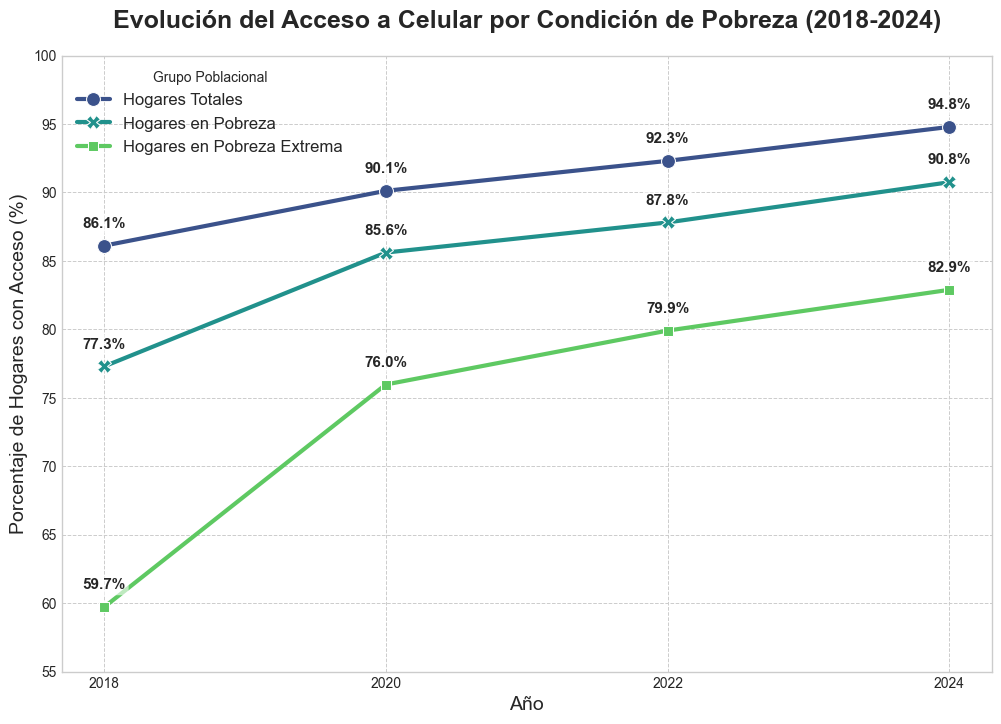

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- VISUALIZACIÓN FINAL: EVOLUCIÓN DEL ACCESO 2018-2024 ---

# 1. Crear el DataFrame con todos los datos
data_evolucion_final = {
    'Año': [2018, 2020, 2022, 2024, 2018, 2020, 2022, 2024, 2018, 2020, 2022, 2024],
    'Grupo': [
        'Hogares Totales', 'Hogares Totales', 'Hogares Totales', 'Hogares Totales',
        'Hogares en Pobreza', 'Hogares en Pobreza', 'Hogares en Pobreza', 'Hogares en Pobreza',
        'Hogares en Pobreza Extrema', 'Hogares en Pobreza Extrema', 'Hogares en Pobreza Extrema', 'Hogares en Pobreza Extrema'
    ],
    'Porcentaje_Acceso': [
        86.11, 90.12, 92.31, 94.79, 
        77.29, 85.61, 87.81, 90.75, 
        59.70, 75.97, 79.91, 82.89
    ]
}
df_evolucion_final = pd.DataFrame(data_evolucion_final)

# 2. Crear el gráfico
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=df_evolucion_final, x='Año', y='Porcentaje_Acceso', hue='Grupo', style='Grupo', 
             palette='viridis', markers=True, dashes=False, lw=3, markersize=10)

# 3. Mejorar el formato del gráfico
ax.set_title('Evolución del Acceso a Celular por Condición de Pobreza (2018-2024)', fontsize=18, pad=20, weight='bold')
ax.set_ylabel('Porcentaje de Hogares con Acceso (%)', fontsize=14)
ax.set_xlabel('Año', fontsize=14)
ax.set_xticks([2018, 2020, 2022, 2024])
ax.set_ylim(55, 100)
ax.legend(title='Grupo Poblacional', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Añadir etiquetas de datos a cada punto
for line in ax.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        ax.text(x, y + 1.1, f'{y:.1f}%', ha='center', va='bottom', fontsize=11, weight='semibold',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

plt.show()